In [1]:
#!/usr/bin/python

import sys
import getopt
import numpy as np
import os
from datetime import datetime, timedelta
from netCDF4 import Dataset
from scipy.interpolate import griddata
from scipy.io import savemat
import PBLmodel
import pygrib
import imp
from scipy import interp

def uv_calc(speed, direction):

    u = np.sin(np.radians(direction))*speed
    v = np.cos(np.radians(direction))*speed
    return u, v


def getIndices(masked,lons, lats, lat_s, lat_n, lon_w, lon_e):
    
    lonStart = lon_w
    lonEnd =  lon_e
    latStart = lat_s
    latEnd = lat_n
    print lonStart, lonEnd, latStart, latEnd
    if lonStart<lonEnd:
        res = np.logical_and(lons >= lonStart, lons <= lonEnd)
    else:
        res = np.logical_or(lons >= lonStart, lons <= lonEnd)
    res = np.logical_and(res == True, lats > latStart)
    res = np.logical_and(res == True, lats < latEnd)
    (i, j) = np.where(res == True)

    if not len(i) or not len(j):
        e = 'There is no wind data in defined area.'
        raise NameError(e)
        
    ind_w, ind_e, ind_s, ind_n = j.min(), j.max(), i.min(), i.max()

    if abs(ind_e - ind_w) > 21:
        c1 = masked[ind_s:ind_n,ind_w:41].count()
        c2 = masked[ind_s:ind_n,41:ind_e].count()
        if c1>c2:
            ind_e = 41
        else:
            ind_w = 41
    indices_list = {"ind_w": int(ind_w), "ind_e": int(ind_e),
                    "ind_s": int(ind_s), "ind_n": int(ind_n)}

    return indices_list




def PressureGradCalc(GS, GD, lat):

    OMEGA = 7.29e-5
    f = 2 * np.sin(np.radians(lat)) * OMEGA
    u_G, v_G = uv_calc(GS, GD)
    dP_y = - u_G * f
    dP_x = v_G * f
    return dP_y, dP_x


def WGS84EarthRadius(lat):

    # http://en.wikipedia.org/wiki/Earth_radius
    WGS84_a = 6378.1370  # Major semiaxis [km]
    WGS84_b = 6356.7523  # Minor semiaxis [km]
    lat = lat * np.pi / 180.0
    An = WGS84_a*WGS84_a * np.cos(lat)
    Bn = WGS84_b*WGS84_b * np.sin(lat)
    Ad = WGS84_a * np.cos(lat)
    Bd = WGS84_b * np.sin(lat)
    return np.sqrt((An*An + Bn*Bn)/(Ad*Ad + Bd*Bd))


def getDistanceLL(loc1, loc2):

    # "Haversine formula- give coordinates as(lat_decimal,lon_decimal) tuples"
    lat1, lon1 = loc1
    lat2, lon2 = loc2
    # earth's mean radius = 6,371km
    earthradius = WGS84EarthRadius((lat1+lat2)/2)
    lon1 = lon1 * np.pi / 180.0
    lon2 = lon2 * np.pi / 180.0
    lat1 = lat1 * np.pi / 180.0
    lat2 = lat2 * np.pi / 180.0
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = (np.sin(dlat/2))**2 + np.cos(lat1) * np.cos(lat2) *\
        (np.sin(dlon/2.0))**2
    c = 2.0 * np.arctan2(np.sqrt(a), np.sqrt(1.0-a))
    km = earthradius * c
    return km


def stretch(f, br):

    nx, ny = f.shape
    new_f = np.zeros((nx + 2*br, ny+2*br))
    new_f[br:nx+br, br:ny+br] = f
    return new_f


def pressureFourier(dX, dY, Rot):

    Ny, Nx = Rot.shape

    Kx = 2*np.pi/dX/Nx * (range(Nx) - (np.ceil(Nx/2)+Nx%2))
    Ky = 2*np.pi/dY/Ny * (range(Ny) - (np.ceil(Ny/2)+Ny%2))
    Kx = np.fft.fftshift(Kx)
    Ky = np.fft.fftshift(Ky)

    KX, KY = np.meshgrid(Kx, Ky)
    K       = np.sqrt(KX**2+KY**2)
    i,j = np.where(K==0)
    K[0,0]    = 10e-19
    v_rot = Rot-np.mean(Rot)
    Rot_f  = np.fft.fft2(v_rot)

    Rot_f[0,0]  = 0
    P_new_f = - Rot_f/K**2
    P_new = np.fft.ifft2(P_new_f);
    P_new = np.real(P_new)
    return P_new


def PressureCalc(ascatPath, oPath, sstPath, ncepPath, dX, borders,
                referencePressure):

    lat_s, lat_n, lon_w, lon_e = borders
    if not os.path.exists(oPath):
        os.makedirs(oPath)

    time_ascat = datetime.strptime(ascatPath.split('/')[-1][6:21],
                                   '%Y%m%d_%H%M%S')

    dataset = Dataset(ascatPath)
    wind_data = {}
    wind_data['wind_speed'] = dataset.variables['wind_speed'][:]
    wind_data['wind_dir'] = dataset.variables['wind_dir'][:]
    wind_data['lats'] = dataset.variables['lat'][:]
    wind_data['lons'] = dataset.variables['lon'][:]
    dataset.close()
    try:
        indices_list = getIndices(wind_data['wind_speed'],wind_data['lons'], wind_data['lats'],
                                  lat_s, lat_n, lon_w, lon_e)
        ind_w = indices_list['ind_w']
        ind_e = indices_list['ind_e']
        ind_s = indices_list['ind_s']
        ind_n = indices_list['ind_n']
        wind = wind_data['wind_speed'][ind_s:ind_n,ind_w:ind_e]
        lats = wind_data['lats'][ind_s:ind_n,ind_w:ind_e]
        lons = wind_data['lons'][ind_s:ind_n,ind_w:ind_e]
        wind_dir = wind_data['wind_dir'][ind_s:ind_n,ind_w:ind_e]
    except Exception as e:
        print e
    
    
    dataset = Dataset(sstPath)
    SST_data = {}
    SST_data['analysed_sst'] = dataset.variables['analysed_sst'][0] - 273.15
    SST_data['lons'], SST_data['lats'] = np.meshgrid(
        dataset.variables['lon'][:], dataset.variables['lat'][:])
    dataset.close()

    SST_data['lons'][SST_data['lons'] < 0] += 360.
    SST = SST_data['analysed_sst']
    lats_sst = SST_data['lats']
    lons_sst = SST_data['lons']
    SST = griddata((lons_sst.ravel(), lats_sst.ravel()),
                   SST.ravel(), (lons, lats))

   
    grbs = pygrib.open(ncepPath)
    temp900 = np.transpose(grbs.select(name='Temperature',
                                       typeOfLevel='isobaricInhPa',
                                       level=900)[0].values *
                           (1000./900.)**0.288 - 273.15)
    temp1000 = np.transpose(grbs.select(name='Temperature',
                                        typeOfLevel='isobaricInhPa',
                                        level=1000)[0].values - 273.15)

    lon_ncep = np.array([0.0 + i for i in xrange(360)])
    lat_ncep = np.array([90.0 - i for i in xrange(181)])
    lats_ncep, lons_ncep = np.meshgrid(lat_ncep, lon_ncep)
    ls = lons
    ls[ls < 0] += 360

    temp1000 = np.ma.masked_array(griddata((lons_ncep.ravel(),
                                            lats_ncep.ravel()),
                                           temp1000.ravel(),(ls,lats)),
                                  mask=wind.mask)
    temp900 = np.ma.masked_array(griddata((lons_ncep.ravel(),
                                           lats_ncep.ravel()),
                                          temp900.ravel(), (ls, lats)),
                                 mask=wind.mask)

    alpha = np.empty_like(wind_dir)
    for i in xrange(lons.shape[1]):

        a = np.arcsin(np.radians(np.sin(
            np.radians(lons[0][i]-lons[1][i])) *
            getDistanceLL([90., 0.], [lats[1][i], lons[1][i]]) /
            getDistanceLL([lats[0][i], lons[0][i]], [lats[1][i], lons[1][i]])))
        alpha[0, i] = a

    for j in xrange(1, lons.shape[0]):
        alpha[j] = alpha[j-1]+np.radians(abs((lons[j-1]-lons[j])))

    wind_dir_n = np.rad2deg(alpha) + wind_dir
    wind_dir_n[wind_dir_n > 360] -= 360
    wind_dir_n[wind_dir_n < 0] += 360
    
    mean_Pressure = 1000.
    GS = np.empty_like(lats)
    GD = np.empty_like(lats)
    dPx = np.empty_like(lats)
    dPy = np.empty_like(lats)

    for index, val in np.ndenumerate(lons):
        if not wind.mask[index]:

            direction = 90 - wind_dir_n[index]
            if direction < 0:
                direction += 360
            windCpx = wind[index] * np.exp(1j * np.radians(direction))
            tempS = (SST[index] + 273.15)*(1000./mean_Pressure)**0.288 - 273.15
            grad = (temp900[index] - temp1000[index])/900.
            try:
                geostrWindCpx, sP = PBLmodel.GeostrophicWindCalc(
                    windCpx=windCpx, tempSurf2=temp900[index] - grad * 1000,
                    tempSurf=tempS, gradient=grad, lat=lats[index], M=2.05)
            except Exception as e:
                print e
                break

            angle = 90 - np.degrees(np.angle(geostrWindCpx))
            if angle < 0:
                angle += 360
            GS[index] = abs(geostrWindCpx)
            GD[index] = angle
            dPy[index], dPx[index] = PressureGradCalc(GS[index],
                                                      GD[index],
                                                      lats[index])

    dPx = np.ma.masked_where(wind.mask, dPx)
    dPy = np.ma.masked_where(wind.mask, dPy)
    br = 100
    dPx_gr = stretch(dPx.filled(0), br)
    dPy_gr = stretch(dPy.filled(0), br)
    lons_gr = stretch(lons, br)
    lats_gr = stretch(lats, br)

    F = (np.gradient(dPx_gr, dX)[1] + np.gradient(dPy_gr, dX)[0])
    P_new = pressureFourier(dX, dX, F)
    P = P_new[br:-br, br:-br]*2.
    lons = lons_gr[br:-br, br:-br]
    lats = lats_gr[br:-br, br:-br]
    plt.imshow(P_new)
    
    
    P0 = griddata((lats.ravel(), lons.ravel()), P.ravel(), 
                  (referencePressure[0],referencePressure[1]))
    
    P0 = interp(referencePressure[0],referencePressure[1], x, y)
    print P0
    
    P = P - P0 + referencePressure[2]*100.
    
    savefileName = 'PressureField_' + time_ascat.strftime('%Y%m%d_%H%M%S')
    savemat(os.path.join(oPath, savefileName), mdict={'P': P,'lons':lons,
                                                      'lats':lats, 'wind':wind.filled(), 
                                                      'wind_dir':wind_dir.filled()})

    return


def main(fileName='main.dat'):

    f = open(fileName)
    data = imp.load_source('data', '', f)
    f.close()
    if data.region == 'spitsbergen':
#         borders = [68., 82., 350., 50.]
        borders = [60., 85., 330., 60.]
    else:
        borders = []
    PressureCalc(data.ascatPath, data.oPath, data.sstPath, data.ncepPath,
                 data.dX, borders, data.referencePressure)
    
    
# if __name__ == "__main__":
#     main()

ImportError: No module named PBLmodel

In [2]:
from scipy.io import loadmat

In [3]:
import math

import mpl_toolkits.basemap as basemap
#import pyproj


def polar_stere(lon_w, lon_e, lat_s, lat_n, **kwargs):
    '''Returns a Basemap object (NPS/SPS) focused in a region.

    lon_w, lon_e, lat_s, lat_n -- Graphic limits in geographical coordinates.
                                  W and S directions are negative.
    **kwargs -- Aditional arguments for Basemap object.

    '''
    lon_0 = lon_w + (lon_e - lon_w) / 2.
    ref = lat_s if abs(lat_s) > abs(lat_n) else lat_n
    lat_0 = math.copysign(90., ref)
    proj = 'npstere' if lat_0 > 0 else 'spstere'
    prj = basemap.Basemap(projection=proj, lon_0=lon_0, lat_0=lat_0,
                          boundinglat=0, resolution='c')
    #prj = pyproj.Proj(proj='stere', lon_0=lon_0, lat_0=lat_0)
    lons = [lon_w, lon_e, lon_w, lon_e, lon_0, lon_0]
    lats = [lat_s, lat_s, lat_n, lat_n, lat_s, lat_n]
    x, y = prj(lons, lats)
    ll_lon, ll_lat = prj(min(x), min(y), inverse=True)
    ur_lon, ur_lat = prj(max(x), max(y), inverse=True)
    return basemap.Basemap(projection='stere', lat_0=lat_0, lon_0=lon_0,
                           llcrnrlon=ll_lon, llcrnrlat=ll_lat,
                           urcrnrlon=ur_lon, urcrnrlat=ur_lat, **kwargs)

In [2]:
import gzip
import bz2

def unGZFile(inFile='', outDir=''):

    fileName, fileExtension = os.path.splitext(inFile)
    print fileName
    if fileExtension == '.gz':  # если файл - архив, то попробовать разархивировать в ту же папку
        inF = gzip.open(inFile, 'rb')
        content = inF.read()
        inF.close()
        outfileName = outDir + fileName.split('/')[-1]
        outF = file(outfileName, 'wb')
        outF.write(content)
        outF.close()
        return outfileName
#         else:
#             raise ValueError("Wrong directory filename")

    else:
        raise ValueError
        
        
def unBZ2File(inFile='', outDir=''):

    fileName, fileExtension = os.path.splitext(inFile)

    if fileExtension == '.bz2':  # если файл - архив, то попробовать разархивировать в ту же папку
        if not os.path.isfile(fileName):    # если файл с таким именем разархивирован, то пропустить его и не трогать
            source = open(inFile, 'rb')
            outfileName = outDir + fileName.split('/')[-1]
            dest = file(outfileName, 'wb')
            dest.write(bz2.decompress(source.read()))
            source.close()
            dest.close()
            return outfileName
        else:
            raise ValueError("Wrong directory filename")
    else:
        raise ValueError

        
def readCSVMeteoData(namefile):
    
    def seek_to_line(f, n):
        for ignored_line in islice(f, n - 1):
            pass   # skip n-1 lines
    
    if namefile.endswith('.gz'):
        if os.path.isfile(os.path.splitext(namefile)[0]):
            namefile =os.path.splitext(namefile)[0]
        else:
            namefile = unGZFile(namefile, os.path.dirname(namefile)+ '/')
        
    
    file = open(namefile, 'r')
    seek_to_line(file, 7)
    Data = [line for line in file]
    keys = Data[0][1:-1].split('";"')
    MeteoData = Data[1:]
    dataDict = {}
    MeteoDataDict = {}
    for line in MeteoData:
        line = line[1:-1].split('";"')
        indx = 0
        for x in keys:
            if indx < len(line):
                dataDict[x] = line[indx]
                indx += 1
        MeteoDataDict[datetime.strptime(dataDict[keys[0]], '%d.%m.%Y %H:%M')] = dataDict.copy()
#         if dataDict['T']:
#             print dataDict['T']
    file.close()
    return MeteoDataDict


def roundTime(dt=None, roundTo=60):
   """Round a datetime object to any time laps in seconds
   dt : datetime.datetime object, default now.
   roundTo : Closest number of seconds to round to, default 1 minute.
   Author: Thierry Husson 2012 - Use it as you want but don't blame me.
   """
   if dt == None : dt =datetime.now()
   seconds = (dt - dt.min).seconds
   # // is a floor division, not a comment on following line:
   rounding = (seconds+roundTo/2) // roundTo * roundTo
   return dt + timedelta(0,rounding-seconds,-dt.microsecond)

In [4]:
from matplotlib import pyplot as plt
from matplotlib import pyplot as plt
%matplotlib inline
import sys
import getopt
import numpy as np
import os
from datetime import datetime, timedelta
from netCDF4 import Dataset
from scipy.interpolate import griddata
import PBLmodel
import pygrib
import imp
from mpl_toolkits.basemap import Basemap
import pytz
from itertools import islice

In [272]:
str(time_ascat.timetuple().tm_yday)

'323'

In [61]:

# fileNameASCAT = 'ascat_20140324_140600_metopa_38542_eps_o_125_2300_ovw.l2.nc.gz'
# fileNameASCAT = 'ascat_20140323_124500_metopa_38527_eps_o_125_2300_ovw.l2.nc.gz'
# fileNameASCAT = 'ascat_20140323_142700_metopa_38528_eps_o_125_2300_ovw.l2.nc.gz'
fileNameASCAT = 'ascat_20140323_110600_metopa_38526_eps_o_125_2300_ovw.l2.nc.gz'
time_ascat = datetime.strptime(fileNameASCAT[6:21], '%Y%m%d_%H%M%S')

dirName = str(time_ascat.timetuple().tm_yday)
oPath = '/home/monzik/ascat_wind/test_Barentsovo/'

iPathASCAT = '/media/SOLabNFS/store/satellite/ascat/preview/L2/metop_a/12km/' + str(time_ascat.year) + '/'

ASCAT = iPathASCAT + dirName.zfill(3) + '/' + fileNameASCAT
ASCAT = unGZFile(inFile=ASCAT, outDir=oPath)

iPathSST = '/media/SOLabNFS/store/satellite/myocean/sst-tac/l4/glob/odyssea/' + str(time_ascat.year) + '/'
fileNameSST=[s for s in sorted(os.listdir(iPathSST+dirName.zfill(3))) if s.endswith('.bz2')][0]
SST = iPathSST + dirName.zfill(3) + '/' + fileNameSST
SST = unBZ2File(inFile=SST, outDir=oPath)

hour = time_ascat.hour
NcepDate = time_ascat
baseHour = round((hour)/6.)*6
if baseHour==24.:
    NcepDate += timedelta(days=1)
    NcepDate=NcepDate.replace(hour=int(0))
else:
    NcepDate=NcepDate.replace(hour=int(baseHour))

NCEP = '/home/monzik/ncep_data/fnl_' + str(NcepDate.year) +'%.2d' %(NcepDate.month) + '%.2d' %(NcepDate.day) + '_' + '%.2d' %(NcepDate.hour) + '_00.grib2'
if not os.path.isfile(NCEP):
    bashCommand1 = 'wget --no-check-certificate -O /dev/null --save-cookies auth.rda.ucar.edu --post-data="email=himemiaanfi@gmail.com&passwd=saint-petersburg&action=login" https://rda.ucar.edu/cgi-bin/login'
    bashCommand2 = 'wget --no-check-certificate -N --load-cookies auth.rda.ucar.edu http://rda.ucar.edu/data/ds083.2/grib2/%s/%s.%s/%s -P ~/ncep_data'%(str(NcepDate.year),str(NcepDate.year),str(NcepDate.month).zfill(2),NCEP.split('/')[-1])
    os.system(bashCommand1)
    os.system(bashCommand2)

st = pytz.timezone('Europe/Oslo')
utc = pytz.utc
time_st = utc.localize(time_ascat)
time_st = time_st.astimezone(st)
data = readCSVMeteoData('/home/monzik/meteo_data/01028.01.12.2013.04.12.2015.1.0.0.ru.ansi.00000000.csv.gz' )
PressureSt = float(data[roundTime(datetime(*time_st.timetuple()[:-4]),roundTo=60*60)]['P']) * 1.33322
 
    
text_file = open("main.dat", "w")

text_file.write("ascatPath = '%s'\n"%ASCAT)
text_file.write("oPath = '%s'\n"%oPath)
text_file.write("sstPath = '%s'\n"%SST)
text_file.write("ncepPath = '%s'\n"%NCEP)
text_file.write("dX = 12500.\n")
text_file.write("region = 'spitsbergen'\n")
text_file.write("referencePressure = [74.52, 19.02, %s]\n"%PressureSt)

text_file.close()
text_file = open(os.path.join(oPath, 'data_' + time_ascat.strftime('%Y%m%d_%H%M%S'))+ '.dat', "w")

text_file.write("ascatPath = '%s'\n"%ASCAT)
text_file.write("oPath = '%s'\n"%oPath)
text_file.write("sstPath = '%s'\n"%SST)
text_file.write("ncepPath = '%s'\n"%NCEP)
text_file.write("dX = 12500.\n")
text_file.write("region = 'spitsbergen'\n")
text_file.write("referencePressure = [74.52, 19.02, %s]\n"%PressureSt)


text_file.close()    

/media/SOLabNFS/store/satellite/ascat/preview/L2/metop_a/12km/2014/082/ascat_20140323_110600_metopa_38526_eps_o_125_2300_ovw.l2.nc


330.0 60.0 60.0 85.0
nan


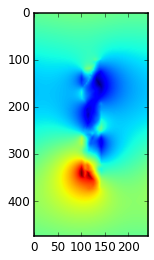

In [74]:
main()

In [75]:
PressureSt

998.4484580000001

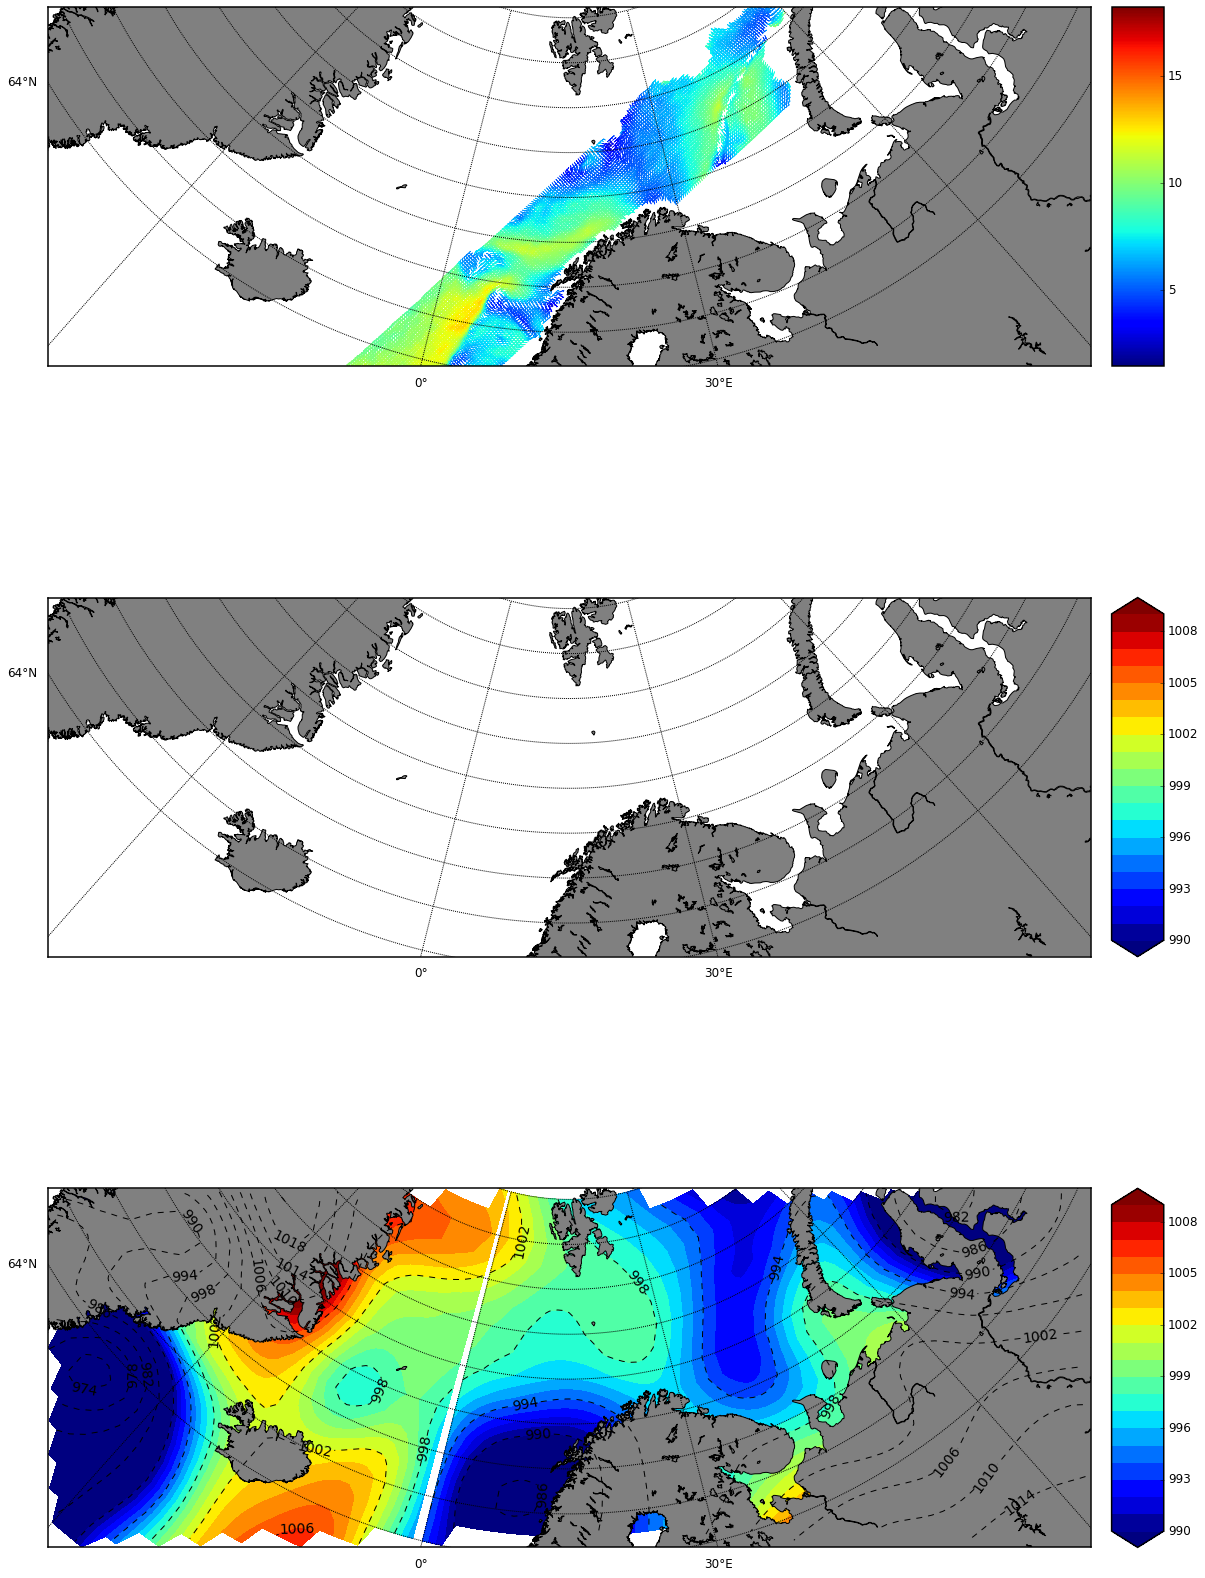

In [68]:
f = open('main.dat')
data = imp.load_source('data', '', f)
f.close()
if data.region == 'spitsbergen':
#     borders = [70., 80., 0., 40.]
    borders = [65., 80., 320., 70.]
else:
    borders = []
    
time_ascat = datetime.strptime(data.ascatPath.split('/')[-1][6:21],
                               '%Y%m%d_%H%M%S')
fileName = 'PressureField_' + time_ascat.strftime('%Y%m%d_%H%M%S')
Pressure_data = loadmat(os.path.join(data.oPath, fileName))

wind = Pressure_data['wind']
wind = np.ma.masked_where(wind<0, wind)
wind_dir = Pressure_data['wind_dir']
wind_dir = np.ma.masked_where(wind.mask, wind_dir)
lats = Pressure_data['lats']
lons = Pressure_data['lons']
P = Pressure_data['P']


grbs = pygrib.open(data.ncepPath)
pp = np.transpose(grbs.select(name='Pressure reduced to MSL')[0].values/100.)




# Set up size of map
minlat, maxlat, minlon, maxlon = borders
if minlon>maxlon:
    minlon = -360 + minlon 
scope = maxlon-minlon
C_Earth = 6371032.
Circ = C_Earth*np.cos(np.radians(minlat))
width = np.pi*Circ*(scope/180.)
height = C_Earth*np.radians((maxlat-minlat+1))
midlon = scope/2.+minlon
midlat = (maxlat-minlat)/2.+minlat
# Prepare Map

# Automated thing to choose appropriate parallels & meridians
division_lon = [30, 10, 5, 2, 1, 0.5, 0.1]
parallels, i = [], 0
while len(parallels) < 4:
    minlatline = 80
    while minlatline > np.floor(minlat):
        minlatline -= division_lon[i]
    parallels = np.arange(minlatline, maxlat, division_lon[i])
    i += 1
meridians, i = [], 0
while len(meridians) < 4:
    minlonline = 360
    while minlonline > np.floor(minlon):
        minlonline -= division_lon[i]
        
    meridians = np.arange(minlonline, maxlon+division_lon[i], division_lon[i])
    
    i += 1
meridians[meridians<0]+=360


plt.close('all')
plt.figure(figsize=(20,30), facecolor='w')
plt.subplot(311)

m = Basemap(width=width, height=height, projection='stere', lat_0=midlat, lon_0=midlon,lat_ts=midlat, resolution='i')
m.drawparallels(parallels, labels=[True,False,False,False])
m.drawmeridians(meridians, labels=[False,False,False,True])
m.drawcoastlines()
m.fillcontinents(color='gray')

x, y = m(lons, lats)
u,v = uv_calc(wind, wind_dir)
u,v =m.rotate_vector(u, v, lons, lats, returnxy=False)

step=1
step2 =1
cc = np.sqrt(u[::step,::step2]**2 + v[::step,::step2]**2)
# cs_wind = m.pcolormesh(x, y, wind, clim = (0,25), cmap = 'jet')
barbs = m.barbs(x[::step,::step2],y[::step,::step2],u[::step,::step2],v[::step,::step2],cc,
                fill_empty=True, rounding=False,
                cmap = 'jet',
                clim = (0, 25),
                length = 3,
                linewidth =  0.7,
                sizes=dict(emptybarb=0.2, spacing=0.2, height=0.4),
                barb_increments=dict(half=2.5, full=5, flag=25)
                      )
m.colorbar(cs_wind,ticks=[0, 5, 10 , 15, 20, 25])
# plt.title('Wind from ASCAT, %s' % (datetime.strftime(time_ascat, '%d %b %Y %H:%M')),
#           color='k', fontsize = 14)


plt.subplot(312)

m = Basemap(width=width, height=height, projection='stere', lat_0=midlat, lon_0=midlon,lat_ts=midlat, resolution='i')
m.drawparallels(parallels, labels=[True,False,False,False])
m.drawmeridians(meridians, labels=[False,False,False,True])
m.drawcoastlines()
m.fillcontinents(color='gray')


# cs2 = m.contourf(x,y,wind*0,colors='lightgrey')
lon_ncep = np.array([0.0 + i for i in xrange(360)])
lat_ncep = np.array([90.0 - i for i in xrange(181)])
lats_ncep,lons_ncep = np.meshgrid(lat_ncep,lon_ncep)
x, y = m(lons_ncep, lats_ncep)
mask1 = x < m.xmin
mask2 = x > m.xmax
mask3 = y > m.ymax
mask4 = y < m.ymin
mask = mask1+mask2+mask3+mask4
pp = np.ma.masked_array(pp,mask=mask)
# lvl = np.arange(np.floor(np.min(pp))-1,np.ceil(np.max(pp))+1,1)

lvl = np.arange(990,1010)
x, y = m(lons, lats)
mask1 = x < m.xmin
mask2 = x > m.xmax
mask3 = y > m.ymax
mask4 = y < m.ymin
mask = mask1+mask2+mask3+mask4
wind = np.ma.masked_array(wind,mask=mask)


P = np.ma.masked_where(np.isnan(P),P )
P = np.ma.masked_array(P,mask=wind.mask)
cs2 = m.contourf(x,y,P/100.,levels=lvl, extend='both')
cs3 = m.contour(x,y,P/100.,levels=np.arange(962,1048,4),linewidths=1,colors='k', linestyles= 'dashed')
plt.clabel(cs3, fontsize=14, inline=True, fmt='%i',rightside_up=True)
cb1 = m.colorbar(cs2)
cb1.locator = tick_locator
cb1.update_ticks()
plt.subplot(313)

m = Basemap(width=width, height=height, projection='stere', lat_0=midlat, lon_0=midlon,lat_ts=midlat, resolution='i')
m.drawparallels(parallels, labels=[True,False,False,False])
m.drawmeridians(meridians, labels=[False,False,False,True])
m.drawcoastlines()
m.fillcontinents(color='gray')
x, y = m(lons_ncep, lats_ncep)

cs = m.contour(x,y,pp,levels=np.arange(962,1048,4),linewidths=1,colors='k', linestyles= 'dashed')
plt.clabel(cs, fontsize=14, inline=True, fmt='%i')
cs1 = m.contourf(x,y,pp,levels=lvl, extend="both")
# plt.clabel(cs, fontsize=12, inline=True, fmt='%i',rightside_up=True)
cb2 = m.colorbar(cs1)
cb2.locator = tick_locator
cb2.update_ticks()

# plt.title('Pressure estimated from ASCAT wind (solid)'+'\n'+' and from NCEP reanalysis (dashed)',color='k', fontsize = 14)
savefileName = 'Picture_' + time_ascat.strftime('%Y%m%d_%H%M%S') + '.png'
plt.savefig(os.path.join(oPath, savefileName), facecolor='w', edgecolor='w',
                        dpi=300, bbox_inches="tight", pad_inches=0.1)


In [13]:
# import matplotlib.font_manager as font_manager
import matplotlib as mpl
# path = '/home/monzik/article/fonts/arial.ttf'
# prop = font_manager.FontProperties(fname=path)
# prop.set_size(16)
# mpl.rcParams['font.family'] = prop.get_name()
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['font.size'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['grid.linewidth'] = 1.5

/usr/local/lib/python2.7/dist-packages/numpy/ma/core.py:3900: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


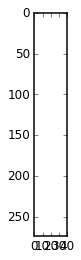

In [70]:
plt.imshow(P)

In [14]:
from matplotlib import ticker

tick_locator = ticker.MaxNLocator(nbins=7)


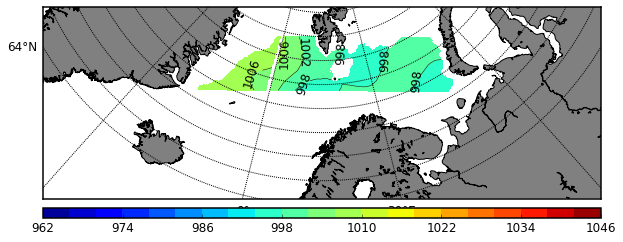

In [24]:
lon_ncep = np.array([0.0 + i for i in xrange(360)])
lat_ncep = np.array([90.0 - i for i in xrange(181)])
lats_ncep,lons_ncep = np.meshgrid(lat_ncep,lon_ncep)
ls = lons
ls[ls<0]+=360
lat_s, lat_n, lon_w, lon_e = borders
grbs = pygrib.open(data.ncepPath)
pp = np.transpose(grbs.select(name='Pressure reduced to MSL')[0].values)




pp = np.ma.masked_array(griddata((lons_ncep.ravel(),lats_ncep.ravel()),pp.ravel(),(ls,lats)),mask=wind.mask)


fig = plt.figure(figsize=(10,20), facecolor='w')
clevs = np.arange(0,15,2)
m = Basemap(width=width, height=height, projection='stere', lat_0=midlat, lon_0=midlon,lat_ts=midlat, resolution='i')
m.drawparallels(parallels, labels=[True,False,False,False])
m.drawmeridians(meridians, labels=[False,False,False,True])
m.drawcoastlines()
m.fillcontinents(color='gray')
x, y = m(lons, lats)
clevs = np.arange(962,1048,4)
cs1 = m.contourf(x,y,pp/100., levels=clevs, cmap='jet')
cs2 = m.contour(x,y,pp/100.,levels=clevs,linewidths=0.5,colors='k')
plt.clabel(cs2, fontsize=12, inline=True, fmt='%i')
cbar = m.colorbar(cs1,location='bottom',pad="5%")

In [33]:
P_new.shape

(280, 41)

In [34]:
dX=12500.
dY=12500.
FX = np.gradient(pp, dX)[1] 
FY = np.gradient(pp, dY)[0] 
br = 100
dPx_gr = stretch(FX.filled(0), br)
dPy_gr = stretch(FY.filled(0), br)
lons_gr = stretch(lons, br)
lats_gr = stretch(lats, br)

F = (np.gradient(dPx_gr, dX)[1] + np.gradient(dPy_gr, dY)[0])


nan


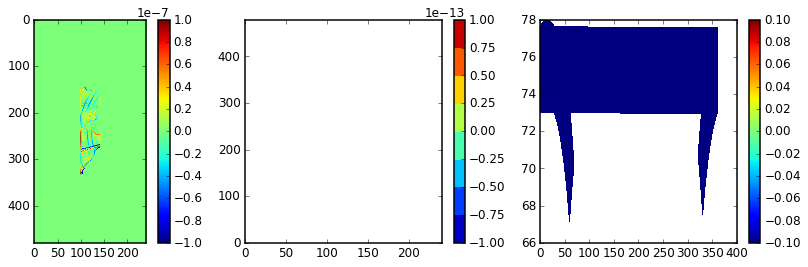

In [50]:
plt.close('all')

x = lons_gr
y = lats_gr



Rot = F

P_new  = pressureFourier(dX, dY, Rot)
P = P_new[br:-br,br:-br]

lons = x[br:-br,br:-br]
lats = y[br:-br,br:-br]

plt.figure(figsize=(15,4))
plt.subplot(131)
plt.imshow(Rot, vmin=-1e-7, vmax=1e-7)
plt.colorbar()
plt.subplot(132)
plt.contourf(P_new)
plt.colorbar()
plt.subplot(133)
plt.pcolormesh(lons,lats,P)
plt.colorbar()


In [49]:
def pressureFourier(dX, dY, Rot):

    Ny, Nx = Rot.shape

    Kx = 2*np.pi/dX/Nx * (range(Nx) - (np.ceil(Nx/2)+Nx%2))
    Ky = 2*np.pi/dY/Ny * (range(Ny) - (np.ceil(Ny/2)+Ny%2))
    Kx = np.fft.fftshift(Kx)
    Ky = np.fft.fftshift(Ky)

    KX, KY = np.meshgrid(Kx, Ky)
    K       = np.sqrt(KX**2+KY**2)
    i,j = np.where(K==0)
    K[0,0]    = 10e-8
#     meanR = np.mean(Rot)*np.ones_like(Rot)
    v_rot = Rot-np.mean(Rot)
    Rot_f  = np.fft.fft2(v_rot)
#     meanR_f = np.fft.fft2(meanR)
    Rot_f[0,0]  = 0
    
    P_new_f = - (Rot_f)/K**2
    print np.mean(Rot)

    P_new = np.fft.ifft2(P_new_f);
    P_new = np.real(P_new)
    return P_new


In [57]:
print Rot

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
